In [1]:
import logging

from utils import logging as lg


lg.set_logging(logging.ERROR)

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cmocean


tf.logging.set_verbosity(tf.logging.ERROR)

import math

from utils import data_provider
from utils import experiment_artifact
from notebook_utils import plot
from model import s2_network, s3_network, provider as model_provider

from heatmap_tutorial import modules, utils

plot.setup()


# Data Preparation

In [3]:
X_train, Y_train = data_provider.get_mnist('train', dir_path='../data/mnist')
X_test, Y_test = data_provider.get_mnist('test', dir_path='../data/mnist')

In [4]:
Y_test_in_number = np.sum(Y_test * np.arange(0, 10), axis=1)
print(Y_test.shape)
print(Y_test_in_number.shape)

(10000, 10)
(10000,)


In [5]:
X_train_2d = np.copy(X_train.reshape((-1,28,28)))
X_test_2d = np.copy(X_test.reshape((-1,28,28)))

In [6]:
x_from_tutorial, y_from_tutorial = utils.getMNISTsample(N=12,path='../data/mnist',seed=1234)
x_from_tutorial = x_from_tutorial.reshape(-1,28,28)

# Visualize Relevance

In [7]:
def get_test_data_in_class(label):
    if label is None:
        return X_test, Y_test
    selector = Y_test_in_number == label
    return X_test[selector, :], Y_test[selector]

def plot_digits(data, limit=200):
    plt.figure(figsize=(20,20))
    count = 1
    for i in range(limit):
        plt.subplot(10,20, count)
        plt.imshow(data[i,:].reshape(28,28))
        plt.xticks([])
        plt.yticks([])
        plt.title(i)
        count = count + 1
    plt.tight_layout()
    plt.show()

In [8]:
x_cls_5, y_cls_5 = get_test_data_in_class(5)

In [9]:
x_cls_all, x_cls_all = get_test_data_in_class(None)

In [10]:
def rel_dist_deep_taylor(model_obj, data):
    
    _, heatmap = model_obj.lrp(data, debug=False)

    no_cols_feed = model_obj._.column_at_a_time
    relevance_dist = np.sum(heatmap.transpose(2,1,0).reshape(model_obj._.seq_length,-1),axis=1)

    return relevance_dist, heatmap

model_obj = model_provider.load('../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22')
rel_dist_dt, heatmap = rel_dist_deep_taylor(model_obj, X_test)

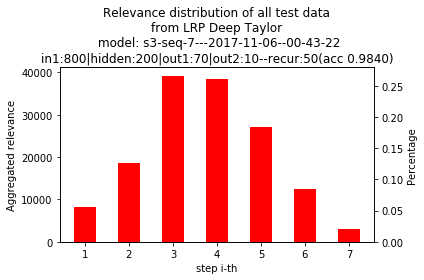

In [80]:
def plot_lrp_dt_relevance_distribution(model_path, label=None):
#     plt.figure(figsize=(8,5))
    fig, ax1 = plt.subplots()
    bar_width= 0.5
    model_obj = model_provider.load(model_path)

    x, _ = get_test_data_in_class(label)

    x_ticks = np.arange(model_obj._.seq_length) + 1

    rel_dist_dt, _ = rel_dist_deep_taylor(model_obj, x)

    ax1.bar(x_ticks, rel_dist_dt, bar_width, color='red')
    ax1.set_xticks(x_ticks)
    ax1.set_xlabel('step i-th')
    
    data_desc = 'all test data'
    if label is not None:
        data_desc = 'class %d' % label
    ax1.set_ylabel('Aggregated relevance')
    ax1.set_title('Relevance distribution of %s\nfrom LRP Deep Taylor\n model: %s\n%s(acc %.4f)' %
             (
                 data_desc,
                 model_obj._.experiment_name,
                 model_obj._.architecture,
                 model_obj._.accuracy,
             ),
            )

    ax2 = ax1.twinx()
    relative_dist = rel_dist_dt / np.sum(rel_dist_dt)
    ax2.bar(x_ticks, relative_dist, bar_width, color='r')
    ax2.set_ylabel('Percentage')
    ax2.tick_params('y')

    fig.tight_layout()
    plt.show()

plot_lrp_dt_relevance_distribution('../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22')

In [117]:
def plot_lrp_relevance_dist_all(model_path):
    fig = plt.figure(figsize=(15,7.5))
    
    rel_dists = []

    model_obj = model_provider.load(model_path)
    for i in [None] + list(range(0,10)):
        x, _ = get_test_data_in_class(i)
        rel_dist_dt, _ = rel_dist_deep_taylor(model_obj, x)
        rel_dists.append(rel_dist_dt)

        
        
    labels = ['All Test Data'] + list(map(lambda x: 'Class %d' % x, range(0,10)))
    x_ticks = np.arange(model_obj._.seq_length) + 1
    
    plt.suptitle('Relevance distribution from LRP Deep Taylor\n model: %s\n%s(acc %.4f)' %
             (
                 model_obj._.experiment_name,
                 model_obj._.architecture,
                 model_obj._.accuracy,
             ),
            )
    
    for i, r in zip(range(len(rel_dists)), rel_dists):
        if i == 0:
            ax = plt.subplot2grid((4, 3), (0, 0), rowspan=2)
        else:
            row_id = int(i/3)
            col_id = i%3
            if row_id >= 1:
                col_id = col_id + 1
                if col_id >= 3:
                    row_id = row_id+1
                    col_id = (col_id)%3
            ax = plt.subplot2grid((4, 3), (row_id, col_id))
    #         print('%d and (%d,%d)' % (i, row_id, col_id))
    # ax0.plot()
        rel_dist = rel_dists[i]

        def plot_bar_chart(axis, data):
            axis.bar(x_ticks, data, 0.5, color='r')
            axis.set_xticks(x_ticks)
        plot_bar_chart(ax, rel_dist)

        ax2 = ax.twinx()

        if i == 0:
            ax.set_ylabel('Aggregated relevance')
            ax.set_xlabel('Step $i$-th')
            ax2.set_ylabel('Percentage')

        relative_dist = rel_dist / np.sum(rel_dist)
        plot_bar_chart(ax2, relative_dist)

        ax.set_title(labels[i])

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    

In [104]:
def plot_weight_proportion(model_path, show_title=False):
    model_obj = model_provider.load(model_path)

    layers = sorted(model_obj.dag.layers.keys())
    total_layers = len(layers)
    idv_size = 4
    plt.figure(figsize=(idv_size*total_layers, idv_size))

    with model_obj.get_session() as sess:
        for i, l in zip(range(total_layers), layers):
            w = model_obj.dag.layers[l].W.eval(session=sess)
            total = (w.shape[0]*w.shape[1])
            w_pos = np.sum(w>0)  / total
            w_neg = np.sum(w<=0)  / total

            plt.subplot(1,total_layers, i+1)
            plt.title('Layer %s' % l)
            plt.pie([w_pos,w_neg], labels=['$W^+$','$W^-_0$'],
                    startangle=90, colors=['r','#EFEFEF'], autopct='%1.0f%%')
    if show_title:
        plt.suptitle('Positive/Negative Weight Proportion in each layer\n model: %s\n%s(acc %.4f)' %
                 (
                     model_obj._.experiment_name,
                     model_obj._.architecture,
                     model_obj._.accuracy,
                 ),
                )
    plt.tight_layout()
    if show_title:
        plt.subplots_adjust(top=0.75)

    plt.show()

## Seq 4

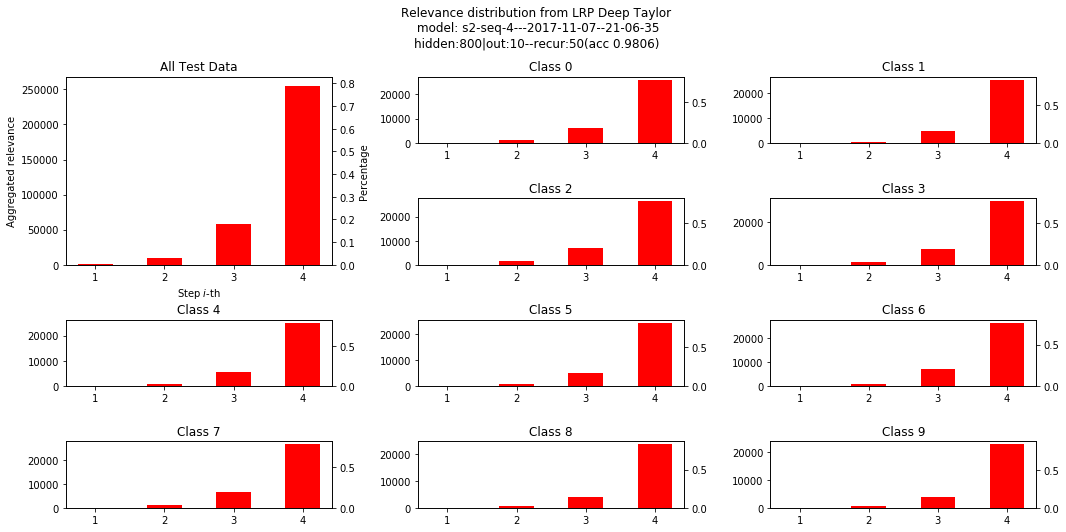

In [118]:
seq_4_s2_model='../experiment-results/sprint-6/s2-seq-4---2017-11-07--21-06-35'
plot_lrp_relevance_dist_all(seq_4_s2_model)

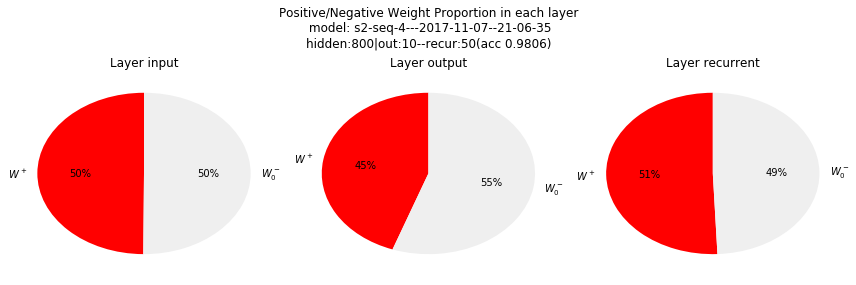

In [105]:
plot_weight_proportion(seq_4_s2_model, show_title=True)

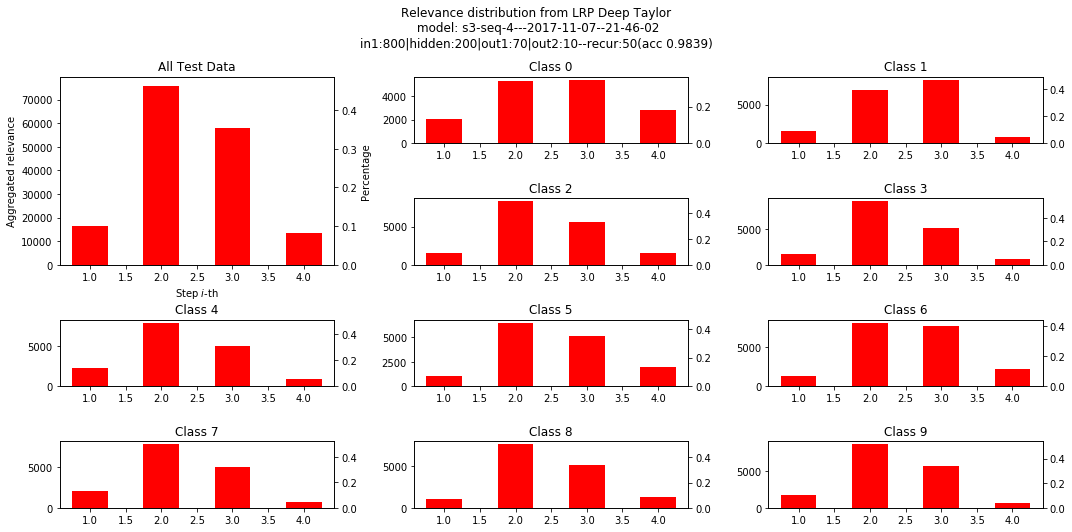

In [106]:
seq_4_s3_model='../experiment-results/sprint-6/s3-seq-4---2017-11-07--21-46-02'
plot_lrp_relevance_dist_all(seq_4_s3_model)

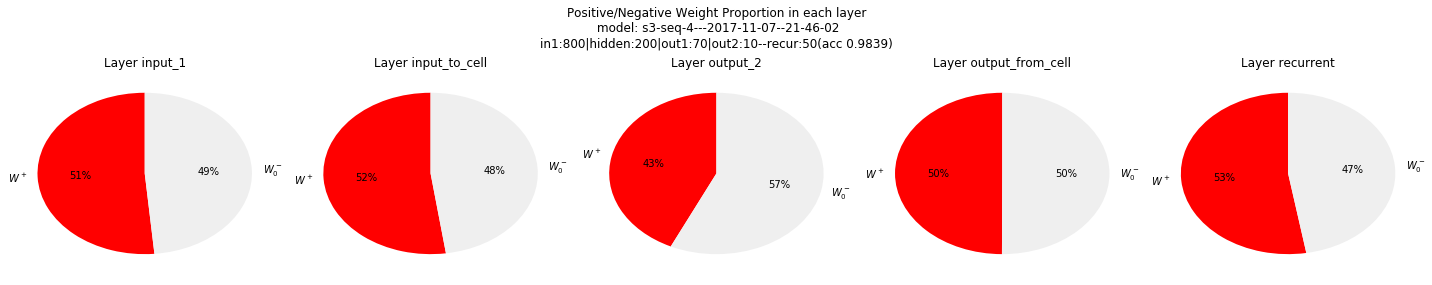

In [107]:
plot_weight_proportion(seq_4_s3_model, show_title=True)

## Seq 7 

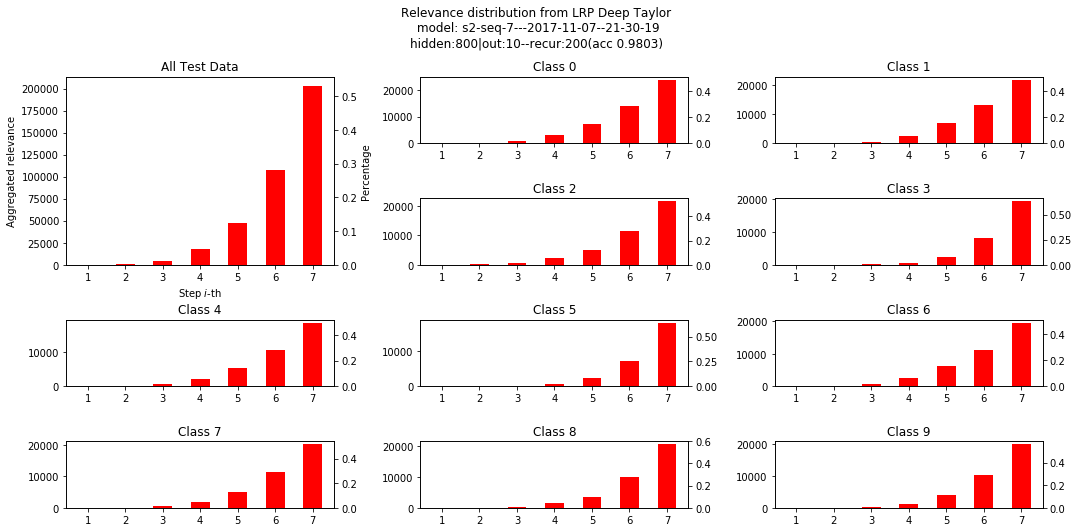

In [108]:
seq_7_s2_model = '../experiment-results/sprint-6/s2-seq-7---2017-11-07--21-30-19'
plot_lrp_relevance_dist_all(seq_7_s2_model)

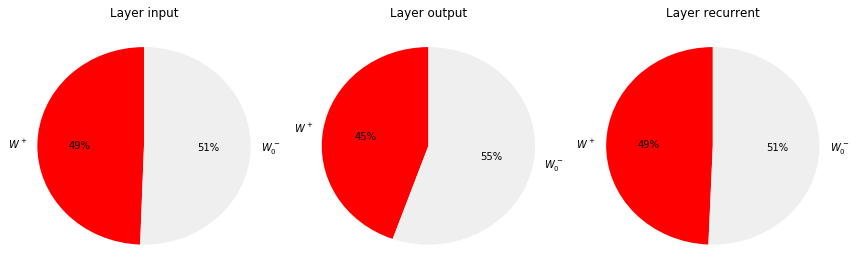

In [116]:
plot_weight_proportion(seq_7_s2_model)

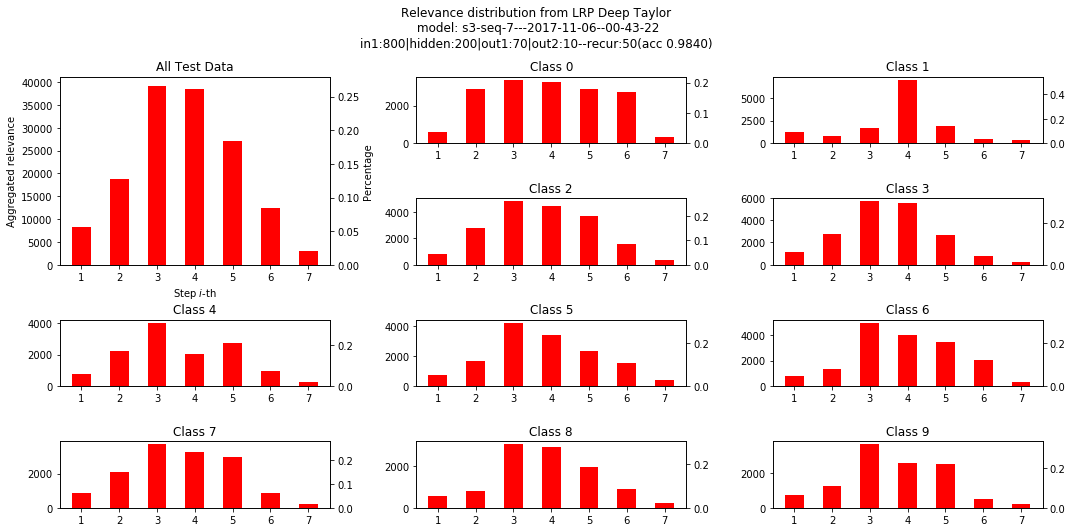

In [114]:
seq_7_s3_model = '../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22'
plot_lrp_relevance_dist_all(seq_7_s3_model)

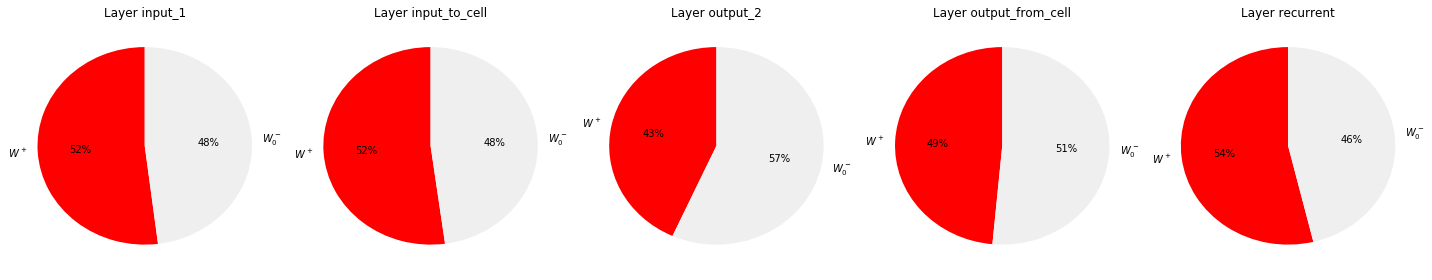

In [115]:
plot_weight_proportion(seq_7_s3_model)

## Seq-14

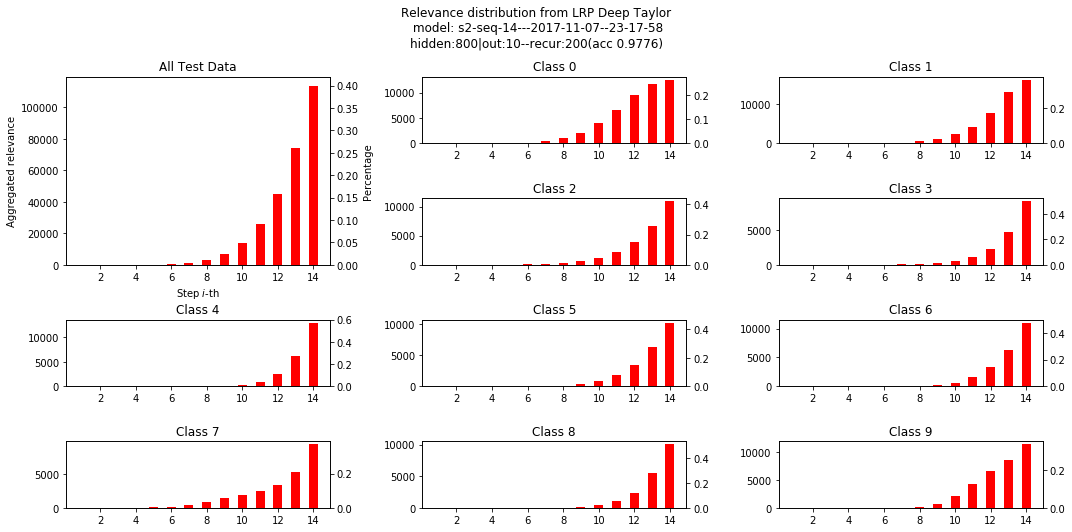

In [110]:
seq_14_s2_model='../experiment-results/sprint-6/s2-seq-14---2017-11-07--23-17-58'
plot_lrp_relevance_dist_all(seq_14_s2_model)

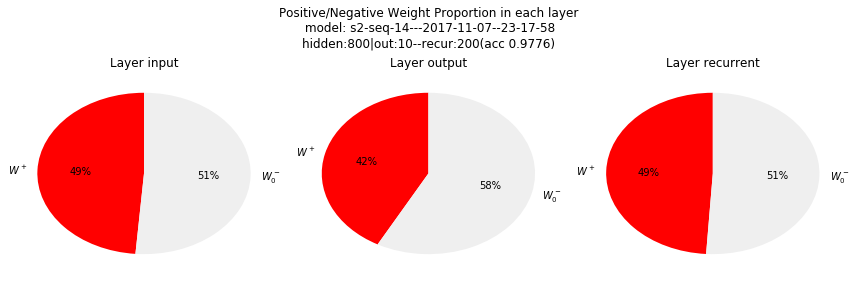

In [113]:
plot_weight_proportion(seq_14_s2_model, show_title=True)

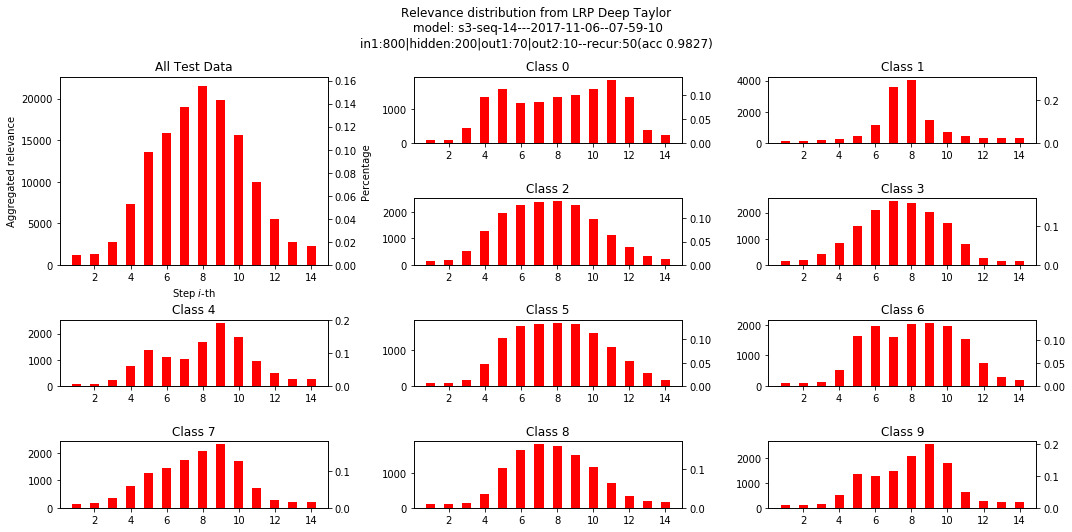

In [111]:
seq_14_s3_model='../experiment-results/sprint-6/s3-seq-14---2017-11-06--07-59-10'
plot_lrp_relevance_dist_all(seq_14_s3_model)

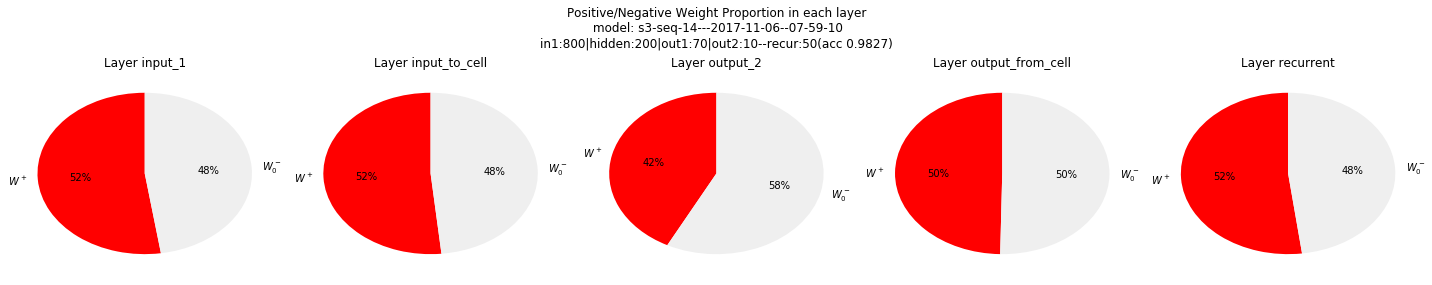

In [112]:
plot_weight_proportion(seq_14_s3_model, show_title=True)

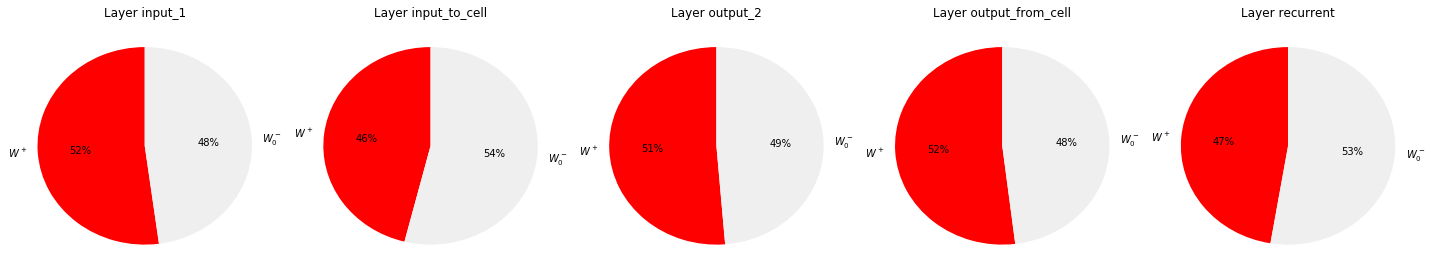

In [82]:
    plt.show()
    
plot_weight_proportion('../experiment-results/sprint-6-improve-dropout-ly/s3-seq-4---2017-11-09--21-29-46')

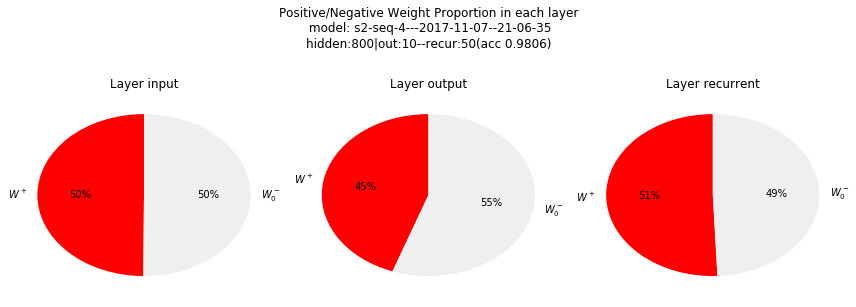

In [44]:
np.sum(weights['input_1'] > 0)

102159

In [45]:
np.sum(weights['input_1'] < 0)

93841

In [40]:
model_obj.dag.layers

{'input_1': <model.components.layer.Layer at 0x117e13da0>,
 'input_to_cell': <model.components.layer.Layer at 0x1508d3390>,
 'output_2': <model.components.layer.Layer at 0x1308ef7b8>,
 'output_from_cell': <model.components.layer.Layer at 0x150378940>,
 'recurrent': <model.components.layer.Layer at 0x118d42cc0>}

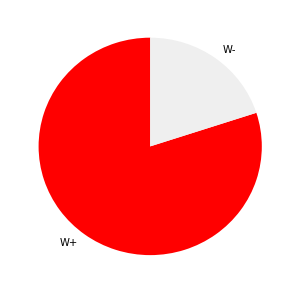

In [31]:
plt.figure(figsize=(5,5))
plt.pie([0.8,0.2], labels=['W+','W-'], startangle=90, colors=['r','#EFEFEF'])
plt.show()

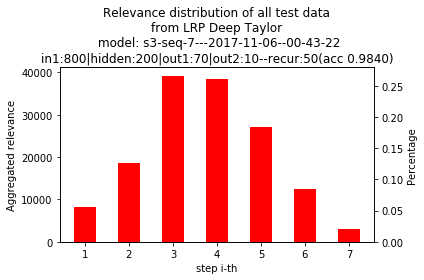

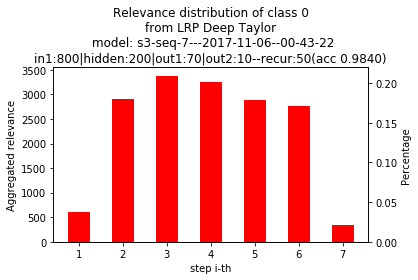

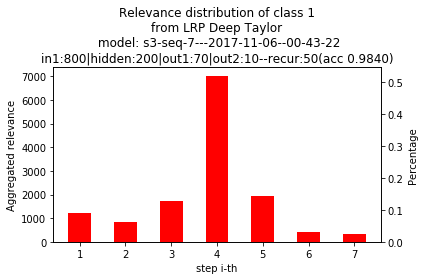

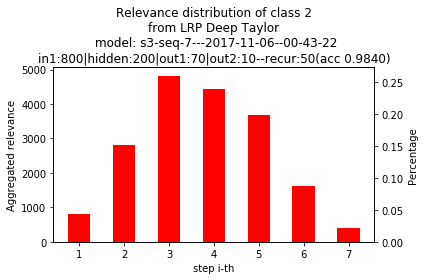

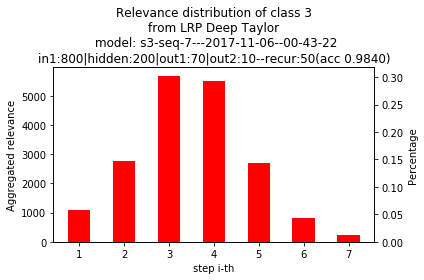

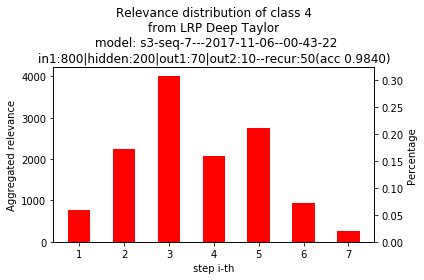

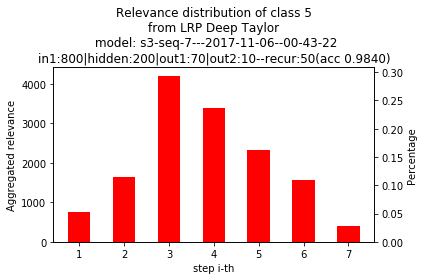

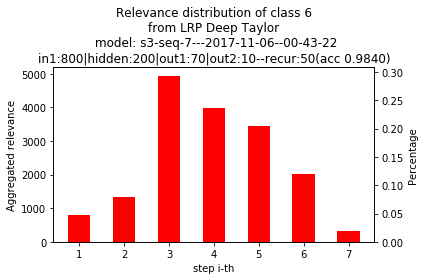

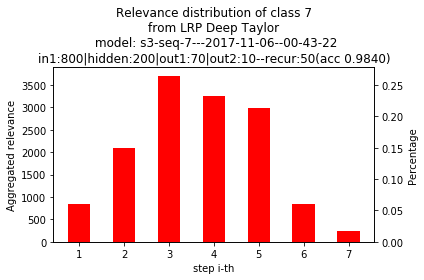

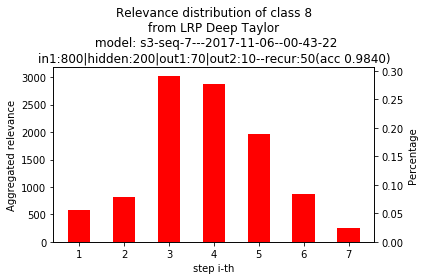

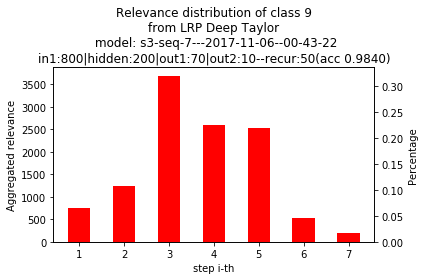

In [82]:
def plot_all_classes(model_path):
    for i in [None] + list(range(0,10)):
        plot_lrp_dt_relevance_distribution(model_path, label=i)
plot_all_classes('../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22')

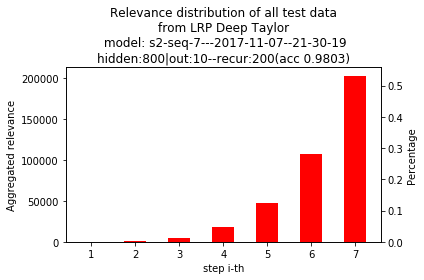

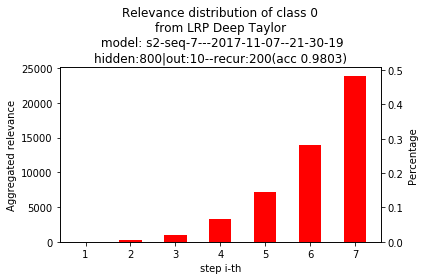

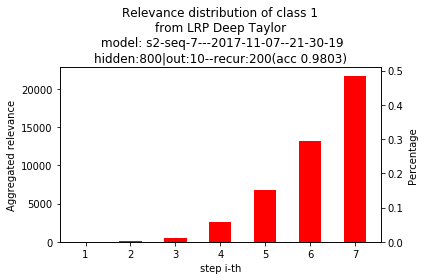

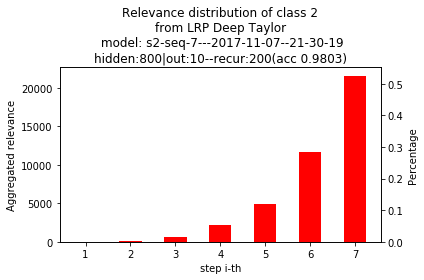

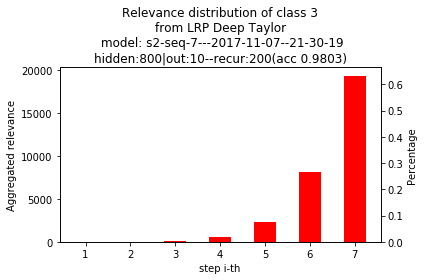

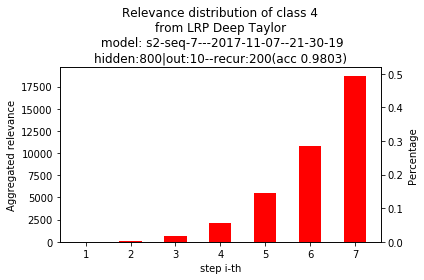

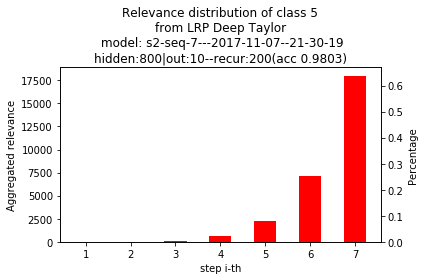

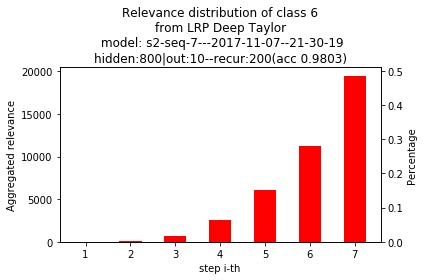

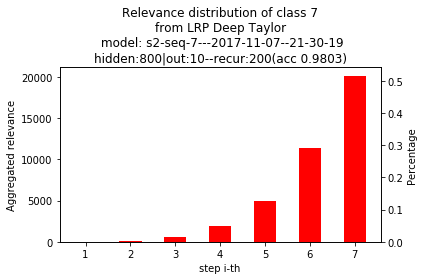

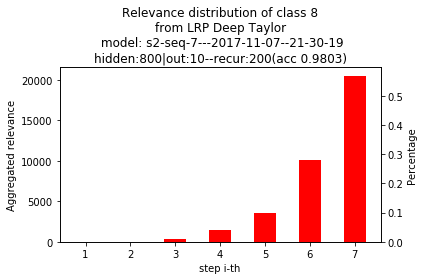

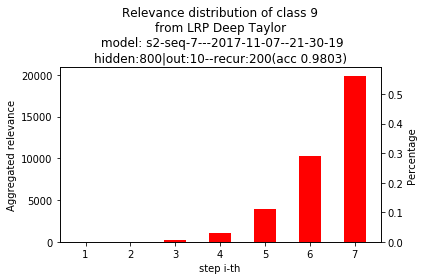

In [83]:
plot_all_classes('')

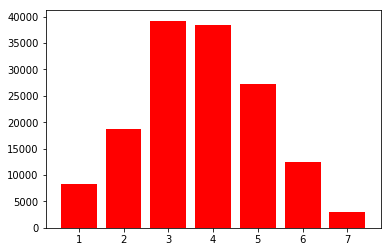

In [26]:
plt.bar(np.arange(7)+1, rel_dist_dt, color='red')
plt.show()

In [62]:
model_obj = model_provider.load('../experiment-results/sprint-6/s3-seq-4---2017-11-07--21-46-02')


In [64]:
model_obj._.column_at_a_time

7

In [65]:
model_obj._

ExperimentArtifact(accuracy=0.9839000105857849, architecture='in1:800|hidden:200|out1:70|out2:10--recur:50', batch=50, column_at_a_time=7, dims=28, epoch=100, experiment_name='s3-seq-4---2017-11-07--21-46-02', lr=0.0001, max_seq_length=28, seq_length=4, path='../experiment-results/sprint-6/s3-seq-4---2017-11-07--21-46-02', architecture_name='s3_network', val_accuracy=0.98224998, keep_prob=0.2, optimizer='AdamOptimizer')

array([  8259.21962578,  18699.10043153,  39225.99083105,  38405.90328113,
        27196.4345498 ,  12387.37202618,   2995.12796159])